# [free operational RAG] Langchain | LangGraph | GROQ | Wevieate | Sentence-Transformers | Tavily | Chainlit

## Query Router | Relevant Grader | Hallucination Grader | Answer Grader

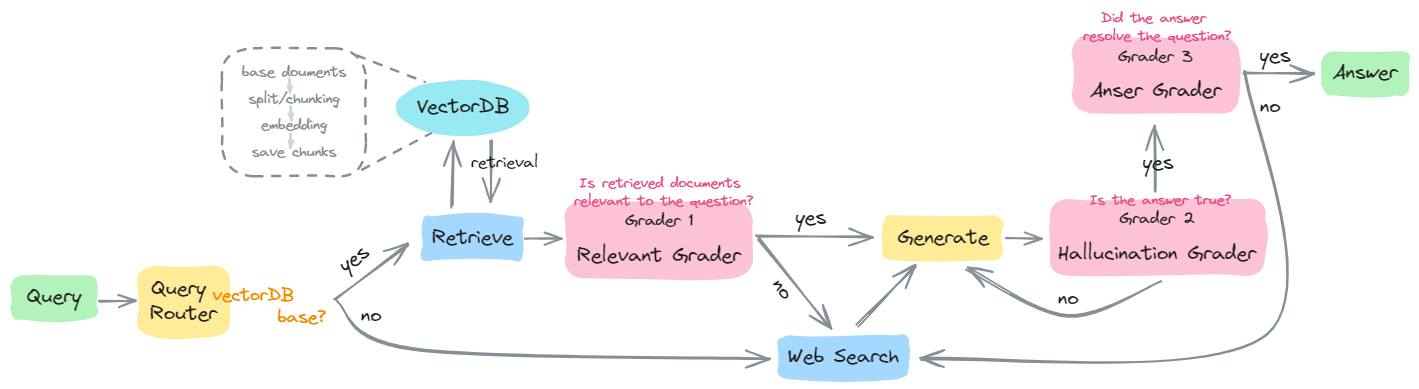

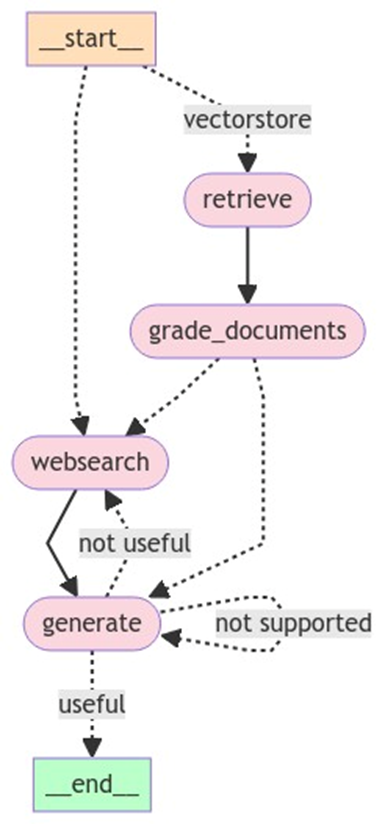

# import

In [2]:
import os
from dotenv import load_dotenv
import weaviate
import json
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
import openai
from langchain_community.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_google_vertexai import VertexAIEmbeddings 
import re
load_dotenv()

USER_AGENT environment variable not set, consider setting it to identify your requests.


False

# API keys

In [3]:
TAVILY_API_KEY = ""
Openai_API_KEY = ""
GROQ_API_KEY = ""
coher_API_KEY = ""

# prepare embedding model (openai)

## openai

In [4]:
os.environ["OPENAI_API_KEY"] =  Openai_API_KEY
openai.api_key =os.getenv("OPENAI_API_KEY")
embed_model = "text-embedding-ada-002"
embeddings = OpenAIEmbeddings(model=embed_model)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [5]:
def get_embedding_openai(text, engine="text-embedding-ada-002") : 
    res = openai.Embedding.create(input=text,engine=engine)['data'][0]['embedding']
    # from openai import OpenAI
    # embedding_client = OpenAI()
    # res= embedding_client.embeddings.create(input = text, model=engine).data[0].embedding
    return res

In [6]:
go=get_embedding_openai("현재 시점 이후의 token들에 대해 masking 처리를 하여 Masked Multi-Head Self-Attention을 사용한다.")

In [7]:
type(go[0])

float

## SentenceTransformer

In [5]:
from sentence_transformers import SentenceTransformer
import numpy as np
embedd_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def get_embedding_st(text) : 
    res = embedd_model.encode(text)
    # res=res.tolist()
    res = list(map(float, res))
    return res

In [10]:
ges=get_embedding_st("LLaMa3의 구조에 대해 알려줘")
type(ges[0])

float

In [11]:
ges

[-0.035624194890260696,
 -0.027902457863092422,
 -0.05851788818836212,
 -0.026916885748505592,
 -0.026761572808027267,
 -0.029205908998847008,
 -0.05547351390123367,
 0.009203432127833366,
 0.04947737231850624,
 0.0536445677280426,
 0.010840702801942825,
 -0.026989251375198364,
 0.04195861145853996,
 0.0020249183289706707,
 0.10465409606695175,
 -0.007751721888780594,
 0.04412725567817688,
 0.04951145127415657,
 -0.0691172257065773,
 -0.023593522608280182,
 0.11661990731954575,
 -0.012899303808808327,
 0.06283784657716751,
 0.006980034522712231,
 -0.008920975029468536,
 0.056600701063871384,
 0.020641572773456573,
 0.03367387503385544,
 0.043169423937797546,
 -0.036984480917453766,
 -0.07175052165985107,
 0.03766687959432602,
 0.02413300983607769,
 -0.06502536684274673,
 -0.044319696724414825,
 -0.06672263145446777,
 -0.0881299301981926,
 0.010020685382187366,
 -0.06994301825761795,
 0.09654732793569565,
 0.00034531031269580126,
 0.024339426308870316,
 0.07674051821231842,
 -0.12915889

# TypedDict (to apply to workflow functions)

In [12]:
from typing_extensions import TypedDict
from typing import List

class GraphState(TypedDict):
    """
    Represents the stat.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents 
    """
    question : str
    generation : str
    web_search : str
    documents : List[str]

# Query Router(web or db)

## Query Router Test / prepare

In [13]:
### Router
# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "websearch"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )

# LLM with function call 
"""
ref.
https://python.langchain.com/v0.2/docs/integrations/chat/groq/
Supported Models: https://console.groq.com/docs/models
"""
llm = ChatGroq(temperature=0, groq_api_key=GROQ_API_KEY)
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt 
# system = """You are an expert at routing a user question to a vectorstore or web search.
# The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
# Use the vectorstore for questions on these topics. For all else, use web-search."""
# route_prompt = ChatPromptTemplate.from_messages(
#     [
#         ("system", system),
#         ("human", "{question}"),
#     ]
# )

# question_router = route_prompt | structured_llm_router
# print(question_router.invoke({"question": "Who will the Bears draft first in the NFL draft?"}))
# print(question_router.invoke({"question": "What are the types of agent memory?"}))

system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to LLM, language processing, and artificial intelligence.
Use the vectorstore for questions on these topics. For all else, use web-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
print(question_router.invoke({"question": "2023년 두산 베어스 1번 타자는 누구야?"}))
print(question_router.invoke({"question": "LLaMa3의 구조에 대해 설명해줘"}))

/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:665: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  response = response.dict()
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:979: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  warnings.warn('The `dict` method is deprecated; use `model_dump` instead.', DeprecationWarning)


datasource='websearch'
datasource='vectorstore'


/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:665: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  response = response.dict()
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:979: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  warnings.warn('The `dict` method is deprecated; use `model_dump` instead.', DeprecationWarning)


## Query Router Def

In [14]:
def route_question(state):
    """
    Route question to web search or RAG 

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})   
    if source.datasource == 'websearch':
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source.datasource == 'vectorstore':
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


# Build VectorDB (Weaviate)

## Test VectorDB

### split / chunking

In [13]:
import requests
from bs4 import BeautifulSoup
request1 = requests.get("https://finddme.github.io/")
html1 = request1.text
soup1 = BeautifulSoup(html1, 'html.parser')
links1 = soup1.select('h4 > a')
urls=[]
tags=["llm","dev","natural"]
for link in links1:
    if link.has_attr('href'):
        href=link.get('href')
        for t in tags:
            if t in href.split("/")[1]:
                urls.append("https://finddme.github.io"+href)

In [14]:
urls

['https://finddme.github.io/llm%20/%20multimodal/2024/07/01/self_ref_rag/',
 'https://finddme.github.io/llm%20/%20multimodal/2024/06/22/merge2/',
 'https://finddme.github.io/llm%20/%20multimodal/2024/06/20/merge/',
 'https://finddme.github.io/llm%20/%20multimodal/2024/06/04/docllm/',
 'https://finddme.github.io/llm%20/%20multimodal/2024/05/30/vlm_models/',
 'https://finddme.github.io/llm%20/%20multimodal/2024/05/29/vlm_architecture/',
 'https://finddme.github.io/llm%20/%20multimodal/2024/05/28/vlm_task/',
 'https://finddme.github.io/llm%20/%20multimodal/2024/05/11/llava/',
 'https://finddme.github.io/llm%20/%20multimodal/2024/05/03/num_gpu/',
 'https://finddme.github.io/llm%20/%20multimodal/2024/05/01/llama3/',
 'https://finddme.github.io/llm%20/%20multimodal/2024/04/04/finetuning_variations/',
 'https://finddme.github.io/llm%20/%20multimodal/2024/02/21/RAG/',
 'https://finddme.github.io/llm%20/%20multimodal/2023/12/04/Mistral/',
 'https://finddme.github.io/llm%20/%20multimodal/2023/10

In [15]:
# urls = [
#     "https://finddme.github.io/llm%20/%20multimodal/2023/10/01/llm_architecture/",
#     "https://finddme.github.io/llm%20/%20multimodal/2024/02/21/RAG/",
#     "https://finddme.github.io/llm%20/%20multimodal/2024/05/01/llama3/",
# ]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

In [75]:
# import re
# space_check=re.compile("\s{1,}")
# re.sub(space_check," ",'Decoder\n    \nencoding 된 representation을을 받아 모델의 출력을 생성하는 부분.\ninput\n        \n학습 시에는 정답 sequence(shifted right)가 입력되고, 추론 시에는 이전에 예측된 token이 입력된다.')

In [16]:
# make chunks
space_check=re.compile("\s{1,}")
chunks=[]
pass_first=["finddme ","⊹  Portfolio","© 2024 viein_serenity_singularity_simplicity_savage. This work is liscensed under CC BY-NC 4.0."]
for i in doc_splits:
    c={'text':i.page_content, 'title':i.metadata["source"].split("/")[-2]}
    if c["text"].split("\n")[0] in pass_first:pass
    else:
        save_c={'text':re.sub(space_check," ",c['text']),'title':c['title']}
        chunks.append(save_c)

<>:2: DeprecationWarning: invalid escape sequence '\s'
<>:2: DeprecationWarning: invalid escape sequence '\s'
/tmp/ipykernel_5358/1419128481.py:2: DeprecationWarning: invalid escape sequence '\s'
  space_check=re.compile("\s{1,}")


In [27]:
len(chunks)

522

In [63]:
chunks

[{'text': 'llama_index -> FlagEmbeddingReranker(?) huggingface rerank model langchain_community -> JinaRerank langchain_cohere -> CohereRerank Application Interface FastAPI (graphic interface o) Flask Gradio (graphic interface o) Streamlit (graphic interface o) cherrypy Django Chainlit ... 기능별 구성 요약 본 포스트에서는 최대한 다양한 Grader가 포함된 pipeline을 다루지만 실용적인 방법이라고는 할 수 없다. pipeline상 단계 별로 LLM을 1~N번 통과해야 하기 때문에 속도가 많이 느려진다. 또한 경우에 따라 Retrieval 결과가 충분하지 않으면 search 단계에서 계속 webserch를 진행할 가능성도 있고, 답변이 충분하지 않은 경우에는 답변 생성을 여러번 할 가능성이 있기 때문에 각 단계별로 최대 진행 횟수를 제한하는 것도 좋은 방법 중 하나이다. Illustrated by the author Illustrated by the author RAG Framework : Langchain Workflow control : LangGraph LLM : Mixtral-8x7b Inference accelerate : GROQ text embedding : Openai vector DB : Wevieate chunk method : RecursiveCharacterTextSplitter web search : Tavily Application Interface : Chainlit Vector DB 준비 : Weaviate Illustrated by the author Weaviate setting 1. weaviate docker setting weaviate docker-compose file: (https://w

## save chunks

In [3]:
# db client 지정

client = weaviate.Client(
    url="http://192.168.2.186:8080"
)

/usr/local/lib/python3.10/dist-packages/weaviate/warnings.py:121: DeprecationWarning: Dep005: You are using weaviate-client version 3.26.2. The latest version is 4.7.1.
            Please consider upgrading to the latest version. See https://weaviate.io/developers/weaviate/client-libraries/python for details.
  warnings.warn(


In [44]:
client.batch.configure(batch_size=100)
# with client.batch as batch:
#     for i, chunk in enumerate(chunks):
#         vector = get_embedding_openai(chunk["text"])
#         batch.add_data_object(data_object=chunk, class_name="Test", vector=vector)
with client.batch as batch:
    for i, chunk in enumerate(chunks):
        try:
            vector = get_embedding_st(chunk["text"])
            # print(type(vector[0]))
            batch.add_data_object(data_object=chunk, class_name="B_ST", vector=vector)
        except Exception as e:
            # print(i, type(vector[0]), chunk)
            print("except",i)
            vector = get_embedding_st(chunk["text"])
            vector=list(map(float, vector))
            batch.add_data_object(data_object=chunk, class_name="B_ST", vector=vector)
            # print("sucsess")
        print("save",i)

save 0
save 1
save 2
save 3
save 4
save 5
save 6
save 7
save 8
save 9
save 10
save 11
save 12
save 13
save 14
save 15
save 16
save 17
save 18
save 19
save 20
save 21
save 22
save 23
save 24
save 25
save 26
save 27
save 28
save 29
save 30
save 31
save 32
save 33
save 34
save 35
save 36
save 37
save 38
save 39
save 40
save 41
save 42
save 43
save 44
save 45
save 46
save 47
save 48
save 49
save 50
save 51
save 52
save 53
save 54
save 55
save 56
save 57
save 58
save 59
save 60
save 61
save 62
save 63
save 64
save 65
save 66
save 67
save 68
save 69
save 70
save 71
save 72
save 73
save 74
save 75
save 76
save 77
save 78
save 79
save 80
save 81
save 82
save 83
save 84
save 85
save 86
save 87
save 88
save 89
save 90
save 91
save 92
save 93
save 94
save 95
save 96
save 97
save 98
save 99
save 100
save 101
save 102
save 103
save 104
save 105
save 106
save 107
save 108
save 109
save 110
save 111
save 112
save 113
save 114
save 115
save 116
save 117
save 118
save 119
save 120
save 121
save 122
sav

### save check

In [56]:
# result = client.query.get("Test", ["text","title"]).do()
result = client.query.get("B_ST", ["text","title"]).do()

In [57]:
result

{'data': {'Get': {'B_ST': [{'text': '3.1 Boolean Acceptability Boolean Acceptability는 언어 표준에 따라 문장이 만족스러운지를 평가하는 방식이다. 해당 모델이 특정 문장에 대해 acceptable하다 혹은 unacceptable하다를 잘 판단했는지 평가하는 것이다. Boolean Acceptability 판단을 위해 fine-tuning을 진행하게 되는데, BERT같은 경우에는 마지막 layer의 [CLS] embedding 상단에 classifier를 추가시킨다. Glove Bow의 경우에는 MLP classifier에 max pooling layer를 추가하여 classifier를 생성했다. 모델의 성능은 예측된 label과 정답 값의 label을 비교하는 MCC로 측정되었다. 3.2 Minimal Pair Minimal Pair(최소대립쌍)은 두 개의 문장이 있을 때 두 문장에서 딱 하나의 token만 다르게 하여 해당 쌍을 비교할 수 있도록 하는 것이다. 여기에서는 Absolute와 Gradient Minimal pair에 대해 실험이 진행된다. 3.2.1 Absolute Minimal Pair 본 실험에서는 두 문장이 paradigm(세 가지 meta-data 변수의 상황) 환경 내에서 NPI와 관련된 Boolean meta-data가 하나만 다를 경우에 최소 대립쌍을 형성하게 되는데, 이때 모델이 한 가지만 다른 것을 제대로 분류할 수 있는지를 확인한다.',
     'title': 'Warstadt'},
    {'text': '2. Classifiers using hand-built features 이번 장에서는 coreference resolution을 위해 logistic regression, SVM 또는 random forest classifier에서 일반적으로 사용되는 feature들에 대해 기술한다. anaphor mention과 potential antecedent me

In [69]:
# https://weaviate.io/developers/weaviate/api/rest_legacy/objects
client.query.aggregate("B_ST").with_meta_count().do()

{'data': {'Aggregate': {'B_ST': [{'meta': {'count': 522}}]}}}

# Retrieval

## Retrieval check

In [7]:
weaviate_class="B_ST"
property_list = list(map(lambda x: x["name"], client.schema.get(weaviate_class)['properties']))
query="LLaMa3의 구조에 대해 설명해줘"
query_vector = get_embedding_st(query)
response = client.query.get(weaviate_class, property_list).with_hybrid(query, vector=query_vector).with_limit(6).do()

In [17]:
response

{'data': {'Get': {'B_ST': [{'text': 'LLaMa 3 LLaMA 3는 Meta에서 공개한 Open Source LLM model로, LLaMa2에 이어 공개된 모델이다. LLaMA 3는 Instruct Model과 Pre-trained Model에 대해 각각 8B, 70B 두 사이즈가 공개되었다. Pretraining과 Post-training 방법의 개선으로 공개된 8B, 70B의 Pretrained, Instruction-fine-tuned model이 2024 4월18일 기준 해당 parameter scale 모델 중 가장 좋은 성능을 보인다고 한다. Post-training과정에서는 false refusal rate를 줄이고, model의 alignment를 개선하고, model response의 다양성을 증가시켰다. 특히 LLaMa 3는 2보다 코드 생성, instruction 수행 능력이 크게 향상되어 모델을 보다 다양하게 활용할 수 있을 것으로 보인다. LLaMa 3 개발 시 Meta팀은 benchmark 성능 향상 뿐만 아니라 실제 추론 능력(real-world scenario) 최적화에도 집중하였다고 한다. 실제 추론 능력 검증을 위해 새로운 high-quality human evaluation set을 개발했다고 한다. 해당 데이터는 12가지 use case에 대한 총 1,800개 prompt로 구성되어 있다. (12가지 use case: asking for advice, brainstorming, classification, closed question answering, coding, creative writing, extraction, inhabiting a character/persona, open question answering, reasoning, rewriting, summarization). 아래 표는 해당 evaluation set에 대한 Claude Sonnet, Mistral Medium, GP

## Retrieval def

In [18]:
def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE from Vector Store DB---")
    question = state["question"]

    # Retrieval
    query_vector = get_embedding_st(question)
    documents = client.query.get("B_ST", ["text","title"]).with_hybrid(question, vector=query_vector).with_limit(6).do()
    return {"documents": documents, "question": question}

# Reranker

ref. 

- https://towardsdatascience.com/how-to-use-re-ranking-for-better-llm-rag-retrieval-243f89414266
- https://blog.stackademic.com/how-to-use-re-rankers-for-advanced-rag-pipelines-using-qdrant-e8ccbfcfaea1"
)"
)

## crossencoder

In [19]:
from sentence_transformers import CrossEncoder
query="LLaMa3의 구조에 대해 설명해줘"
cross_encoder = CrossEncoder(
    "cross-encoder/ms-marco-MiniLM-L-12-v2", max_length=512, device="cpu"
)
sentence_pairs = [[query, rr["text"]] for rr in response["data"]["Get"]["B_ST"]]
similarity_scores = cross_encoder.predict(sentence_pairs)

In [20]:
paired_list = list(zip(similarity_scores, response["data"]["Get"]["B_ST"]))

paired_list.sort(key=lambda x: x[0],reverse=True)

sorted_b = [item[1] for item in paired_list]

response["data"]["Get"]["B_ST"]=sorted_b

In [21]:
def reranker_ce(state):
    print("---Reranking---")
    question = state["question"]
    documents = state["documents"]
    
    # Rerank
    sentence_pairs = [[question, rr["text"]] for rr in documents["data"]["Get"]["B_ST"]]
    similarity_scores = cross_encoder.predict(sentence_pairs)
    paired_list = list(zip(similarity_scores, documents["data"]["Get"]["B_ST"]))
    paired_list.sort(key=lambda x: x[0],reverse=True)
    sorted_b = [item[1] for item in paired_list]
    documents["data"]["Get"]["B_ST"]=sorted_b
    return {"documents": documents, "question": question}

# FlagEmbedding

In [120]:
from FlagEmbedding import FlagReranker
reranker_model = FlagReranker('BAAI/bge-reranker-v2-m3', use_fp16=True, device="cpu") 

In [121]:
sentence_pairs = [[query, rr["text"]] for rr in response["data"]["Get"]["B_ST"]]
similarity_scores = reranker_model.compute_score(sentence_pairs)

In [123]:
# a와 b를 튜플로 묶어줍니다.
paired_list = list(zip(similarity_scores, response["data"]["Get"]["B_ST"]))

# a를 기준으로 정렬합니다.
paired_list.sort(key=lambda x: x[0],reverse=True)

# 정렬된 b 리스트를 얻습니다.
sorted_b = [item[1] for item in paired_list]

response["data"]["Get"]["B_ST"]=sorted_b

In [125]:
def reranker_fr(state):
    print("---Reranking---")
    question = state["question"]
    documents = state["documents"]
    
    # Rerank
    sentence_pairs = [[question, rr["text"]] for rr in documents["data"]["Get"]["B_ST"]]
    similarity_scores = reranker_model.compute_score(sentence_pairs)
    paired_list = list(zip(similarity_scores, documents["data"]["Get"]["B_ST"]))
    paired_list.sort(key=lambda x: x[0],reverse=True)
    sorted_b = [item[1] for item in paired_list]
    documents["data"]["Get"]["B_ST"]=sorted_b
    return {"documents": documents, "question": question}

# Grader 1 : Relevant Grader

- 검색된 doc이 relevant한지 아닌지 확인

Corrective RAG (CRAG): https://finddme.github.io/llm%20/%20multimodal/2024/02/21/RAG/#5-corrective-rag-crag

## Relevant Grader test / prepare

In [77]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
"""
pydantic_v1
- https://python.langchain.com/v0.1/docs/modules/model_io/output_parsers/types/pydantic/
- 특정 schema에 맞게 output을 구성하도록 LLM에 quary할 수 있게하는 parser.
"""
# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

# LLM with function call 
structured_llm_grader_docs = llm.with_structured_output(GradeDocuments)

# Prompt 
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader_relevance = grade_prompt | structured_llm_grader_docs

doc_txt=""
for idx,i in enumerate(response["data"]["Get"]["B_ST"]):
    t=i["text"]
    doc_txt += f"doc {idx}. {t} \n"

retrieval_grader_relevance.invoke({"question": query, "document": doc_txt})

/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:665: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  response = response.dict()
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:979: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  warnings.warn('The `dict` method is deprecated; use `model_dump` instead.', DeprecationWarning)


GradeDocuments(binary_score='yes')

## Relevant Grader def

In [78]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents["data"]["Get"]["B_ST"]:
        score = retrieval_grader_relevance.invoke({"question": question, "document": d["text"]})
        grade = score.binary_score
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}

# Generate

## Generate test / prepare

In [80]:
from langchain_core.output_parsers import StrOutputParser # 출력물을 기본 str 형태로 받는 라이브러리

# Prompt
# prompt = ChatPromptTemplate.from_template(
#     """You are an Korean assistant for question-answering tasks. 
#     Use the following pieces of retrieved context to answer the question. 
#     If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
#     And you must answer in Korean.
# Question: {question}
# Context: {context}
# Answer:"""
# )

prompt = ChatPromptTemplate.from_template(
    """You are a Korean-speaking assistant specializing in question-answering tasks. 
    All answers must be written in Korean.
    Use the provided context informations and relevant documents to answer the following question as accurately as possible. 
    If the answer is not clear from the context or if you do not know the answer, explicitly state "모르겠습니다." (I don't know). 
    Use three sentences maximum and keep the answer concise.
    All responses must be given in Korean.
    Based on the given information, return a very detailed response.
Question: {question}
Context: {context}
Answer:
"""
)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": doc_txt, "question": query})
print(generation)

LLaMa 3은 Meta에서 공개한 Open Source LLM 모델로, LLaMa 2보다 최신 모델입니다. LLaMa 3에는 Instruct Model과 Pre-trained Model이 각각 8B, 70B 두 사이즈로 공개되었으며, 이는 Pretraining과 Post-training 방법의 개선을 통해 발전된 모델입니다. 특히, Post-training 과정에서 false refusal rate를 줄이고, model의 alignment을 개선하여 model response의 다양성을 증가시켰습니다. LLaMa 3는 코드 생성, instruction 수행 능력이 크게 향상되어, 모델을 보다 다양하게 활용할 수 있습니다. LLaMa 3 개발 시, Model architecture, Training data, Scaling up pretraining, Instruction fine-tuning을 중점적으로 개선하였습니다.


/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:665: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  response = response.dict()
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:979: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  warnings.warn('The `dict` method is deprecated; use `model_dump` instead.', DeprecationWarning)


## Generate def

In [81]:
def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE Answer---")
    question = state["question"]
    documents = state["documents"]
    
    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

# Grader 2 : Hallucination Grader

In [82]:
# Data model
# BaseModel: pydantic_v1
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(description="Don't consider calling external APIs for additional information. Answer is supported by the facts, 'yes' or 'no'.")
 
# LLM with function call 
structured_llm_grader_hallucination = llm.with_structured_output(GradeHallucinations)
 
# Prompt 
system = """You are a grader assessing whether an LLM generation is supported by a set of retrieved facts. \n 
     Restrict yourself to give a binary score, either 'yes' or 'no'. If the answer is supported or partially supported by the set of facts, consider it a yes. \n
    Don't consider calling external APIs for additional information as consistent with the facts."""

hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
]
)
  
hallucination_grader = hallucination_prompt | structured_llm_grader_hallucination
hallucination_grader.invoke({"documents": doc_txt, "generation": generation})

/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:665: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  response = response.dict()
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:979: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  warnings.warn('The `dict` method is deprecated; use `model_dump` instead.', DeprecationWarning)


GradeHallucinations(binary_score='yes')

# Grader 3 : Answer Grader

ref. 

- https://pub.towardsai.net/llms-can-self-reflect-ad7ec3962be4

## Answer Grader test / prepare

In [83]:
### Answer Grader 

# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(description="Answer addresses the question, 'yes' or 'no'")

# LLM with function call 
structured_llm_grader_answer = llm.with_structured_output(GradeAnswer)

# Prompt 
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader_answer
answer_grader.invoke({"question": query,"generation": generation})

/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:665: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  response = response.dict()
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:979: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  warnings.warn('The `dict` method is deprecated; use `model_dump` instead.', DeprecationWarning)


GradeAnswer(binary_score='yes')

# Hallucination + Answer Grader def

In [84]:
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke({"documents": documents, "generation": generation})
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question,"generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

# Web search

## Web search test / prepare

### Tavily

In [85]:
from tavily import TavilyClient
tavily = TavilyClient(api_key=TAVILY_API_KEY)

In [86]:
response = tavily.search(query="LLaMa3 구조에 대해 알려줘")

In [87]:
[d["content"] for d in response["results"]]

['GPT-4에 비견할만한 성능을 가진다는 Meta의 오픈소스 LLM Llama3를 사용해보자! Llama 3 모델 Llama 3 모델 특징8B & 70B 파라미터 규모의 모델으로, MMLU, HumanEval 등 벤치마크 태스크에서 경쟁모델보다 좋은 성능을 보임Decoder-only 트랜스포머 아키텍처를 기본으로 하되, Llama2 대비 큰 향상을 보임토큰 인코딩 ...',
 'Llama 3는 오픈 소스 대규모 언어 모델의 진화에서 중요한 이정표를 나타내며 성능, 기능 및 책임 있는 개발 방식의 한계를 뛰어 넘었습니다. 혁신적인 아키텍처, 대규모 훈련 데이터세트, 최첨단 미세 조정 기술을 갖춘 Llama 3는 8B 및 70B 매개변수 규모에서 LLM에 ...',
 '서울과학기술대학교 임경태 교수 연구진들이 공개한 Llama 3 모델을 100GB에 달하는 한국어 데이터셋으로 풀 파인튜닝 한 Bllossom 모델을 소개드립니다. 이미 Bllossom은 Llama 2 때부터 버전업을 해온 모델이더군요. 이번에 V2.0으로 업그레이드 하였고 RLHF가 아닌 DPO ...',
 '메타에서 최근 공개한 오픈소스 대형 언어 모델인 라마3를 다양한 방식으로 사용해보는 방법을 알아봅니다. 허깅페이스, 메타 AI 서비스, 로컬 PC 등에서 Llama3를 활용하는 방안을 소개합니다. Assistant에서 Llama3를 사용 할수 있는 방법에 대해 알아봅니다.',
 '사후 훈련 과정을 정제함으로써, llama3는 복잡한 질의에 대해 더 잘 이해하고 대응할 수 있어 출력 결과가 관련성이 있고 주제에 부합하도록 할 수 있습니다. 거짓 거절 비율을 낮추는 것은 llama3의 또 다른 주요 개선 영역입니다. 이전 언어 모델은 종종 필요한 ...']

### langchain_community

ref.

DUCKDUCKGO: https://python.langchain.com/v0.2/docs/integrations/tools/ddg/

Wikipedia: https://python.langchain.com/v0.2/docs/integrations/tools/wikipedia/

arXiv: https://python.langchain.com/v0.2/docs/integrations/tools/arxiv/


- https://blog.gopenai.com/unleash-the-power-of-multiple-data-sources-building-advanced-rag-q-a-with-langchain-98368a084cde
- https://generativeai.pub/make-the-web-your-best-friend-data-provider-16e1a2a31024

In [88]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langchain_community.tools import DuckDuckGoSearchResults
from langchain.tools.retriever import create_retriever_tool
from langchain_community.utilities import ArxivAPIWrapper
from langchain_community.tools import ArxivQueryRun
import os

In [89]:
# CREATING DUCKDUCKGO SEARCH WRAPPER
ddg_wrapper = DuckDuckGoSearchAPIWrapper(max_results=1)
search = DuckDuckGoSearchResults(api_wrapper=ddg_wrapper)

In [90]:
search.run("LLaMa3 구조에 대해 알려줘")

"[snippet: Llama 3는 오픈 소스 대규모 언어 모델의 진화에서 중요한 이정표를 나타내며 성능, 기능 및 책임 있는 개발 방식의 한계를 뛰어 넘었습니다. 혁신적인 아키텍처, 대규모 훈련 데이터세트, 최첨단 미세 조정 기술을 갖춘 Llama 3는 8B 및 70B 매개변수 규모에서 LLM에 ..., title: Llama 3에 대해 알아야 할 모든 것 | 가장 강력한 오픈 소스 모델 | 사용 개념 - Unite.AI, link: https://unite.ai/ko/Lama-3에-대해-알아야-할-모든-것-가장-강력한-오픈-소스-모델이자-사용법-개념/], [snippet: The Llama 3 release introduces 4 new open LLM models by Meta based on the Llama 2 architecture. They come in two sizes: 8B and 70B parameters, each with base (pre-trained) and instruct-tuned versions. All the variants can be run on various types of consumer hardware and have a context length of 8K tokens. Meta-Llama-3-8b: Base 8B model., title: Welcome Llama 3 - Meta's new open LLM - Hugging Face, link: https://huggingface.co/blog/llama3], [snippet: 사후 훈련 과정을 정제함으로써, llama3는 복잡한 질의에 대해 더 잘 이해하고 대응할 수 있어 출력 결과가 관련성이 있고 주제에 부합하도록 할 수 있습니다. 거짓 거절 비율을 낮추는 것은 llama3의 또 다른 주요 개선 영역입니다. 이전 언어 모델은 종종 필요한 ..., title: Llama-3-8B와 Llama-3-70B: Meta의 오픈소스 LLM 모델에 대한 간략한 소개 - AI

In [91]:
# Wikipedia Wrapper 
api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

In [92]:
wiki.run("LLaMa3 구조에 대해 알려줘")

'No good Wikipedia Search Result was found'

In [93]:
# arXiv Wrapper
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=200)
arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper)

In [94]:
arxiv.run("LLaMa3 구조에 대해 알려줘")

/usr/local/lib/python3.10/dist-packages/langchain_community/utilities/arxiv.py:156: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  ).results()


'Published: 2024-04-22\nTitle: How Good Are Low-bit Quantized LLaMA3 Models? An Empirical Study\nAuthors: Wei Huang, Xudong Ma, Haotong Qin, Xingyu Zheng, Chengtao Lv, Hong Chen, Jie Luo, Xiaojuan Qi, Xi'

## Web search def

In [95]:
from langchain.schema import Document
def web_search_tavily(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH. Append to vector store db---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    tavily_response = tavily.search(query=question,search_depth="advanced")
    tavily_response2 = tavily.qna_search(query=question, search_depth="advanced",max_results =3)
    web_results = "\n".join([d["content"] for d in tavily_response["results"]])
    web_results+=f"\n{tavily_response2}"
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    source = [{"source_title":" ","source":"web search result"}]
    return {"documents": documents, "question": question, "source": source}

In [96]:
def web_search_ddg(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH. Append to vector store db---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    search_res=search.run(question)
    search_res1=[]
    for s in search_res.split(", title:"):
        search_res1.append(s.replace("[snippet: ","").replace("]",""))
    web_results="\n".join(search_res1)
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    return {"documents": documents, "question": question}

In [97]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---")
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

# set Graph

In [126]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search_ddg", web_search_ddg) # web search # key: action to do
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("grade_documents", grade_documents) # grade documents
workflow.add_node("generate", generate) # generatae

workflow.add_node("reranker_fr",reranker_fr)
workflow.add_edge("web_search_ddg", "generate") #start -> end of node
workflow.add_edge("retrieve", "reranker_fr")
workflow.add_edge("reranker_fr", "grade_documents")

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "web_search_ddg",
        "vectorstore": "retrieve",
    },
)
 
workflow.add_conditional_edges(
    "grade_documents", # start: node
    decide_to_generate, # defined function
    {
        "websearch": "web_search_ddg", #returns of the function
        "generate": "generate",   #returns of the function
    },
)

workflow.add_conditional_edges(
    "generate", # start: node
    grade_generation_v_documents_and_question, # defined function
    {
        "not supported": "generate", #returns of the function
        "useful": END,               #returns of the function
        "not useful": "web_search_ddg",   #returns of the function
    },
)

# Compile
app = workflow.compile()

# Run Graph

In [127]:
from pprint import pprint
inputs = {"question": "LLaMa3에 대해 설명해줘"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---ROUTE QUESTION---


/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:665: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  response = response.dict()
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:979: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  warnings.warn('The `dict` method is deprecated; use `model_dump` instead.', DeprecationWarning)


---ROUTE QUESTION TO RAG---
---RETRIEVE from Vector Store DB---
'Finished running: retrieve:'
---Reranking---
'Finished running: reranker_fr:'
---CHECK DOCUMENT RELEVANCE TO QUESTION---


/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:665: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  response = response.dict()
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:979: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  warnings.warn('The `dict` method is deprecated; use `model_dump` instead.', DeprecationWarning)


---GRADE: DOCUMENT RELEVANT---


/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:665: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  response = response.dict()
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:979: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  warnings.warn('The `dict` method is deprecated; use `model_dump` instead.', DeprecationWarning)


---GRADE: DOCUMENT RELEVANT---


/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:665: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  response = response.dict()
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:979: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  warnings.warn('The `dict` method is deprecated; use `model_dump` instead.', DeprecationWarning)


---GRADE: DOCUMENT NOT RELEVANT---


/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:665: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  response = response.dict()
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:979: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  warnings.warn('The `dict` method is deprecated; use `model_dump` instead.', DeprecationWarning)


---GRADE: DOCUMENT RELEVANT---


/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:665: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  response = response.dict()
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:979: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  warnings.warn('The `dict` method is deprecated; use `model_dump` instead.', DeprecationWarning)


---GRADE: DOCUMENT RELEVANT---


/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:665: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  response = response.dict()
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:979: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  warnings.warn('The `dict` method is deprecated; use `model_dump` instead.', DeprecationWarning)


---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
'Finished running: grade_documents:'
---WEB SEARCH. Append to vector store db---
'Finished running: web_search_ddg:'
---GENERATE Answer---


/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:665: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  response = response.dict()
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:979: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  warnings.warn('The `dict` method is deprecated; use `model_dump` instead.', DeprecationWarning)


---CHECK HALLUCINATIONS---


/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:665: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  response = response.dict()
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:979: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  warnings.warn('The `dict` method is deprecated; use `model_dump` instead.', DeprecationWarning)


---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
'Finished running: generate:'
('LLaMa3은 Meta에서 공개한 Open Source LLM(Large Language Model) 모델입니다. LLaMa2를 이어 '
 '발표된 모델로, Instruct Model과 Pre-trained Model의 두 가지 사이즈로 공개되었습니다. 8B와 70B 파라미터 '
 '규모로, MMLU, HumanEval 등 벤치마크 태스크에서 경쟁모델보다 좋은 성능을 보이는 Decoder-only 트랜스포머 아키텍처를 '
 '기반으로 구축되었습니다. LLaMa3는 특히 코드 생성과 인스트럭션 수행 능력이 크게 향상되어, 다양한 방식으로 활용할 수 있습니다. '
 'LLaMa3는 성능 개선뿐만 아니라, 실제 추론 능력을 최적화하기 위해 새로운 high-quality human evaluation '
 'set을 개발하였습니다.')


/usr/local/lib/python3.10/dist-packages/langchain_groq/chat_models.py:665: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  response = response.dict()
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:979: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  warnings.warn('The `dict` method is deprecated; use `model_dump` instead.', DeprecationWarning)


In [84]:
print(value["generation"])

LLaMa 3은 Meta에서 개발한 Open Source LLM(Large Language Model) 모델로, LLaMa 2를 이어 발표된 모델입니다. 이 모델은 Instruct Model과 Pre-trained Model로 8B, 70B 두 사이즈가 공개되었으며, 2024년 4월 18일 기준 해당 파라미터 스케일 모델 중 가장 좋은 성능을 보이고 있습니다. LLaMa 3는 코드 생성, instruction 수행 능력이 크게 향상되어 모델을 보다 다양하게 활용할 수 있습니다. 이 모델은 standard decoder-only transformer architecture를 기반으로 하며, 128K token 수를 가진 vocab을 사용하여 언어를 보다 효과적으로 encoding합니다. LLaMa 3는 15T 개의 token으로 학습되었으며, 이는 LLaMa 2보다 약 7배 더 큰 학습 데이터를 사용하였습니다.


# Graph visualization

ref. https://langchain-ai.github.io/langgraph/how-tos/visualization/#using-mermaid-pyppeteer

In [78]:
print(app.get_graph().draw_mermaid())

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__[__start__]:::startclass;
	__end__[__end__]:::endclass;
	websearch([websearch]):::otherclass;
	retrieve([retrieve]):::otherclass;
	grade_documents([grade_documents]):::otherclass;
	generate([generate]):::otherclass;
	retrieve --> grade_documents;
	websearch --> generate;
	__start__ -.-> websearch;
	__start__ -. vectorstore .-> retrieve;
	grade_documents -.-> websearch;
	grade_documents -.-> generate;
	generate -. not supported .-> generate;
	generate -. useful .-> __end__;
	generate -. not useful .-> websearch;
	classDef startclass fill:#ffdfba;
	classDef endclass fill:#baffc9;
	classDef otherclass fill:#fad7de;



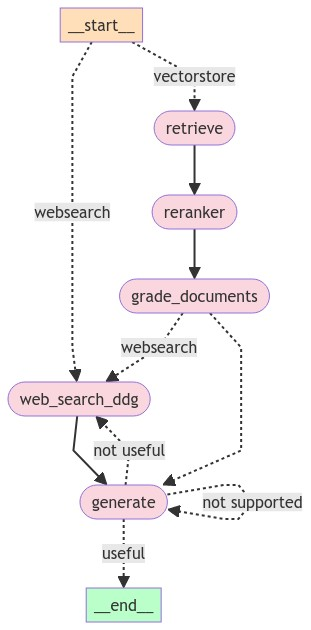

In [116]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeColors

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

# Chainlit

In [1]:
"""
# python script로 실행
# command:
# chainlit run rag_chainlit.py -w --port 8000 --host 0.0.0.0

from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
import chainlit as cl

@cl.on_message
async def run_convo(message: cl.Message):
    #"what is the weather in sf"
    inputs = {"question": message.content}
    cb = cl.AsyncLangchainCallbackHandler(stream_final_answer=True)
    config = RunnableConfig(callbacks=[cb])
    
    # res = app.invoke(inputs, config=RunnableConfig(callbacks=[
    #     cl.LangchainCallbackHandler(
    #         # to_ignore=["ChannelRead", "RunnableLambda", "ChannelWrite", "__start__", "_execute"]
    #         # can add more into the to_ignore: "agent:edges", "call_model"
    #         # to_keep=

    #     )]))
    res = await app.ainvoke(inputs,config=config)
    # await cl.Message(content=res["question"][-1].content).send()
    await cl.Message(content=res["generation"]).send()
"""

'\n# python script로 실행\n# command:\n# chainlit run chainlit.py -w --port 8000 --host 0.0.0.0\n\nfrom langchain_core.messages import HumanMessage\nfrom langchain_core.runnables import RunnableConfig\nimport chainlit as cl\n\n@cl.on_message\nasync def run_convo(message: cl.Message):\n    #"what is the weather in sf"\n    inputs = {"question": message.content}\n    cb = cl.AsyncLangchainCallbackHandler(stream_final_answer=True)\n    config = RunnableConfig(callbacks=[cb])\n    \n    # res = app.invoke(inputs, config=RunnableConfig(callbacks=[\n    #     cl.LangchainCallbackHandler(\n    #         # to_ignore=["ChannelRead", "RunnableLambda", "ChannelWrite", "__start__", "_execute"]\n    #         # can add more into the to_ignore: "agent:edges", "call_model"\n    #         # to_keep=\n\n    #     )]))\n    res = await app.ainvoke(inputs,config=config)\n    # await cl.Message(content=res["question"][-1].content).send()\n    await cl.Message(content=res["generation"]).send()\n'

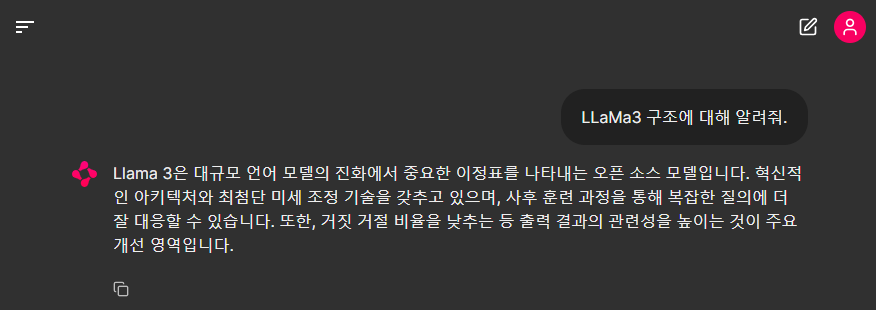